In [1]:
%pylab inline
import uncertainties
from uncertainties import ufloat as ufloat
from uncertainties import unumpy as unp
from numpy import array as array

# Daten einlesen
def read (path,offset=2, *kwargs):
    from numpy import array as array
    doc = []
    with open (path+".TKA", 'r') as myfile:
        data = myfile.read().replace(',', '.').replace('\n', ',').replace('  ', ',').replace("\t",",")
        datarray = data.split(',')
        output = []
    for item in datarray:
        if item != '':
            output.append(int(item))
    dataset = array(output[offset:])
    dataset = [array(range(len(dataset))), dataset]
    return dataset

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fit_pm(x, y, func=lambda x: x, p0=None):
    """
        fit_pm takes data points and makes an exponential curve fit. It returns
        the parameters with errors and the coefficient of determination
        Parameters:
        -----------
        x: x-value of the data points.
        y: y-value of the data points.
        func: Function to be fitted to.
        Returns:
        -----------
        list: Gives back a list with the parameters of an expotential function the
              corresponding errors and the coefficient of determination.
    """
    from scipy.optimize import curve_fit
    import numpy as np
    popt, pcov = curve_fit(func, val(x), val(y),sigma=err(y), p0=p0)
    params = popt.copy()
    errors = np.sqrt(np.diag(pcov))
    r = np.array(y) - func(np.array(x), *params)
    rss = np.sum(r ** 2)
    tss = np.sum((y - np.mean(y)) ** 2)
    R_2 = 1 - (rss / tss)
    try:
        from uncertainties import unumpy as unp
        return unp.uarray(params, errors), R_2
    except:
        return np.array(params), np.array(errors), R_2

def linfit_pm(x, y, p0=None):
    return fit_pm(x, y, func=lambda x, a, b,: a * x + b, p0=p0)

def val(x):
    from uncertainties import unumpy
    try:
        return unumpy.nominal_values(x)
    except TypeError:
        return x

def err(x):
    from uncertainties import unumpy
    return unumpy.std_devs(x)

def gaus(x, mu, sigma, A, B):
    import numpy as np
    return B + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2))

def gausfit_pm(x, y, p0=None):
    import numpy as np
    return fit_pm(x, y, func=lambda x, mu, sigma, A, B: B + A * np.e ** ((-1 * (x - mu) ** 2) / (2 * sigma ** 2)), p0=p0)

In [3]:
data1_r = [[0,1,2,3,4,5,6,7,8,9,10,12.5,15,20,25,30,40,50,60,70,80],[1500,1480,1453,1428,1352,1180,979,880,576,350,208,108,101,101,104,99,77,77,77,71,79]]
backg = [ufloat(90,0.01),ufloat(759,np.sqrt(759))]
data2_r = [[0,1,2,3,4,5,6,7,8,9,10,12.5,15,20,25,30,40,60,80,90],
         [1495,1404,1386,1314,1104,906,616,450,300,192,119,99,99,104,98,90,66,80,70,95]]

errs1 = (0.01,0.5,0.5,0.5,0.5,0.01,0.5,0.5,0.5,0.5,0.01,0.5,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01)
errs2 = (0.01,0.5,0.5,0.5,0.5,0.01,0.5,0.5,0.5,0.5,0.01,0.5,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01)
data1 = (unp.uarray(data1_r[0],errs1),unp.uarray(data1_r[1],[sqrt(item) for item in data1_r[1]]))
data2 = (unp.uarray(data2_r[0],errs2),unp.uarray(data2_r[1],[sqrt(item) for item in data2_r[1]]))         

In [4]:
data = []
data.append(concatenate(
    [-data1[0],
     #backg[0]/1000,
     data2[0]]))
data.append(concatenate([data1[1]/100,
                         #backg[1]/1000,
                         data2[1]/100]))
backg[1] /= 1000
#data[0] =concatenate(array([list(data[0]),[-1*backg[0]]]))
#data[1] = concatenate(array([list(data[1]),[backg[1]]]))
data[1]-=backg[1]


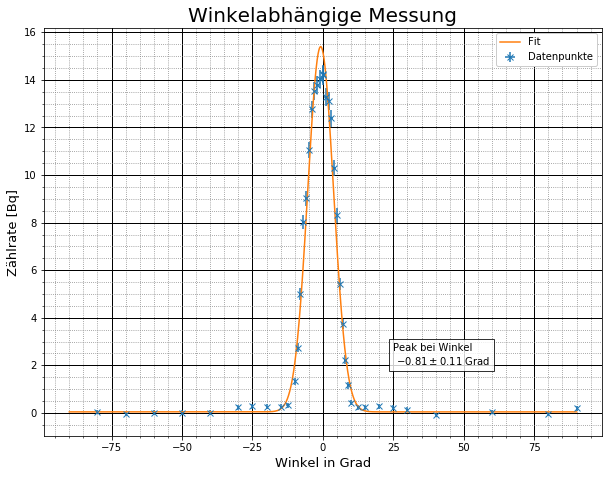

In [17]:
#plt.errorbar(val(data[0]),val(data[1]),yerr=err(data[1]),xerr=err(data[0]),fmt="x")
peak, perr = gausfit_pm(*data,p0=(0,10,14,0))
x = np.arange(-90,90,0.01)
y = gaus(x,*peak)
#plt.plot(x,val(y))
#plt.show()

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 7.5
plt.rcParams["figure.figsize"] = fig_size

###   Errors / Fit / Plot
plt.errorbar(val(data[0]),val(data[1]),yerr=err(data[1]),xerr=err(data[0]),fmt="x", label="Datenpunkte")
plt.plot(x,val(y), label="Fit")
plt.text(25,2, r"Peak bei Winkel"+"\n"+" ${:L}$ Grad".format(peak[0]),
          bbox={'facecolor':'white', 'alpha':0.8}, fontsize=10)



###   Label / Title

plt.ylabel(r'Zählrate [Bq]', fontsize=13)
plt.xlabel(r'Winkel in Grad', fontsize=13)
plt.title('Winkelabhängige Messung', fontsize=20)

###   Axes / Grid

axes = plt.gca()  ##  Searches current Axes

#axes.set_xlim([0,1024])
#axes.set_ylim([0,220000])

#axes.set_yticks([0,10,20,30,40,50,60,70,80,90,100,110])
#axes.set_xticks([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8])

axes.grid(which='major', linestyle='-', linewidth='1', color='black')
axes.grid(which='minor', linestyle=':', color='gray')
axes.minorticks_on()

plt.legend(framealpha=1)
plt.savefig('Winkel.png')
plt.show()

In [13]:
peak

array([-0.8062988864344501+/-0.11033195246424068,
       4.578195767372925+/-0.09553848761938857,
       15.358947747991051+/-0.38354441378223614,
       0.04142470602989676+/-0.061339564080818774], dtype=object)

In [14]:
perr

0.984510150814158+/-0.0053419224343752795

In [10]:
y.argmax()
max(y)

15.400363849257376